In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

import sys
if 'google.colab' in sys.modules:
    !pip install pdpbox
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install plotly==4.*
    !pip install sklearn
    !pip install eli5
    !pip install shap
    !pip install xgboost


https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists



# 1. Import Dataset

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error, accuracy_score, roc_auc_score
from scipy.stats import randint, uniform


from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


import lightgbm as lgb

train = pd.read_csv("aug_train.csv")
test = pd.read_csv("aug_test.csv")
test_id = test['enrollee_id']
target = ['target']

y_train = train[target]
X_train = train.drop(target, axis = 1)

X_train.shape, test.shape

((19158, 13), (2129, 13))

# Data Description

* **enrollee_id** : 지원자의 고유번호

* **city**: 도시 고유코드

* **city_development_index** : 산업개발정도 (스케일링 된 수치)

* **gender**: 성별

* **relevent_experience**: 지원자의 유사경험 여부

* **enrolled_university**: 대학 수업 지원 여부

* **education_level**: 학력

* **major_discipline** : 전공

* **experience**: 경력년도

* **company_size**: 현재 직장의 사원 수

* **company_type** : 현재 직장의 유형

* **last_new_job**: 현재 직장과 이전 직장의 근무년도 차이

* **training_hours**: 교육 수행시간

* **target**: 

    0 – 데이터직군으로 전직을 희망하지 않음

    1 – 데이터직군으로 전직을 희망함

# 2. EDA

## Pandas Profile

In [ ]:
from pandas_profiling import ProfileReport

prof = ProfileReport(X_train).to_notebook_iframe()

## 데이터 EDA 아이디어

* enrollee_id -> 제거

* city와 city_development_index의 랭글링하여 상관관계 확인 또는 시티별 평균 index구하기

* education_level과 major_discipline관계성 파악하여 결측치 처리

* education_level과 enrolled_university또한 관계성 파악 및 결측치 처리

* relevant_experience와 experience를 통한 결측치 처리

* relevant_experience와 last_new_job에서 결측치 처리

* training_hours는 right skewed -> log-transform

# Missing Value

In [ ]:
# A Percentage of Missing Values
100*X_train.isnull().sum()/len(X_train)

enrollee_id                0.000000
city                       0.000000
city_development_index     0.000000
gender                    23.530640
relevent_experience        0.000000
enrolled_university        2.014824
education_level            2.401086
major_discipline          14.683161
experience                 0.339284
company_size              30.994885
company_type              32.049274
last_new_job               2.207955
training_hours             0.000000
dtype: float64

### 도시와 관련된 특성
* city  
* city_development_index

In [ ]:
city_wrangling = X_train.groupby('city')['city_development_index'].agg(['count','mean']).sort_values('count', ascending = False).reset_index()
city_wrangling

,city,count,mean
0,city_103,4355,0.920
1,city_21,2702,0.624
2,city_16,1533,0.910
3,city_114,1336,0.926
4,city_160,845,0.920
...,...,...,...
118,city_111,3,0.698
119,city_129,3,0.625
120,city_121,3,0.781
121,city_171,1,0.664


### 경험과 관련된 특성

* relevent_experience
* experience 
* last_new_job 
* company_size           
* company_type



#### 관련경험을 제외한 모든 경험과 관련된 특성에 결측값이 있는 경우

* Work experience가 없다고 판단


In [ ]:
# 관련경험을 제외한 모든 experience related feature에 결측값이 있는 경우
cond = ((X_train['last_new_job'].isnull()) &
        (X_train['company_size'].isnull()) & 
        (X_train['company_type'].isnull()) & 
        (X_train['experience'].isnull())
        )
X_train[cond]

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
135,23947,city_103,0.920,NaN,No relevent experience,no_enrollment,Phd,STEM,NaN,NaN,NaN,NaN,70
391,12038,city_90,0.698,Male,Has relevent experience,Full time course,Masters,NaN,NaN,NaN,NaN,NaN,44
2727,14965,city_103,0.920,NaN,Has relevent experience,no_enrollment,Masters,STEM,NaN,NaN,NaN,NaN,70
3564,15273,city_103,0.920,NaN,Has relevent experience,no_enrollment,Masters,STEM,NaN,NaN,NaN,NaN,34
4336,17123,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,NaN,NaN,NaN,NaN,32
9793,1435,city_103,0.920,NaN,No relevent experience,no_enrollment,High School,NaN,NaN,NaN,NaN,NaN,4
17018,15198,city_103,0.920,Male,No relevent experience,Full time course,NaN,NaN,NaN,NaN,NaN,NaN,21


In [ ]:
X_train.loc[cond, 'last_new_job'] = 'never'
X_train.loc[cond, 'company_size'] = 'No current Job'
X_train.loc[cond, 'company_type'] = 'No current Job'
X_train.loc[cond, 'experience'] = 0

#### Experience

In [ ]:
X_train['experience'].value_counts(normalize = True)

>20    0.172042
5      0.074869
4      0.073455
3      0.070890
6      0.063665
2      0.059005
7      0.053822
10     0.051571
9      0.051309
8      0.041990
15     0.035916
11     0.034764
14     0.030681
1      0.028743
<1     0.027330
16     0.026597
12     0.025864
13     0.020890
17     0.017906
19     0.015916
18     0.014660
20     0.007749
0      0.000366
Name: experience, dtype: float64

In [ ]:
#### ---------------------------- 'experience' ---------------------------- ####
experience_features = ['relevent_experience', 'experience','last_new_job', 'company_size', 'company_type']
# NaN in 'experience' having 'last_new_job' value
exp_missing = ((X_train['experience'].isnull()) &
               ~(X_train['last_new_job'].isnull()) 
               )
## Replace them into the equal info of 'last_new_job'
X_train.loc[exp_missing, 'experience'] = X_train.loc[exp_missing, 'last_new_job']

# -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - #
# Company informations exist without either 'experience' or 'last_new_job' info
exp_missing2 = ((X_train['experience'].isnull()) &
               ~(X_train['company_size'].isnull() & X_train['company_type'].isnull()) 
               )
## Replace them into '<1' as the minimum
X_train.loc[exp_missing2, 'experience'] = '<1'
X_train.loc[exp_missing2, 'experience'] = '1'


# -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - #
# Replace them into...
X_train['experience'] = X_train['experience'].str.replace('>20','20') # '>20' -> 20
X_train['experience'] = X_train['experience'].str.replace('<1','0.5') # '<1' -> 0.5 
X_train['experience'] = X_train['experience'].str.replace('>4','4.5') # '>4' -> 5 
X_train['experience'] = X_train['experience'].str.replace('never','0') # 'never' -> 0 

# -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - #
# Other missing values of 'experience' = 0 & 'last_new_job' = 'never'
exp_missing3 = (X_train['experience'].isnull())
X_train.loc[exp_missing3,'experience'] = '0'

exp_missing3 = (X_train['last_new_job'].isnull())
X_train.loc[exp_missing3,'last_new_job'] = 'never'

# Convert it into integer
X_train['experience'] = X_train['experience'].astype('float')


### last_new_job

현 직장 또는 과거의 직장이 첫 직장으로 판단 => 'never' 전환


#### 현재 근무중인 회사의 정보

* Company Size 
* Company Type




In [ ]:
# Randomized values based on prior distribution of individual company type or size to fill out missing values of each
###################################################################################
#### ------------------- 'company_type' & 'company_size' ------------------- ####

# type list & size list
company_type_list = X_train['company_type'].value_counts().index.tolist()
company_size_list = X_train['company_size'].value_counts().index.tolist()

#### ---------------------------- 'company_size' ---------------------------- ####
### ------- Data wrangling with 'company_type' &'company_size' features ------ ###
type_per_size = (X_train
 .groupby(['company_type','company_size'])
 .count()
 .reset_index()[['company_type','company_size','city']]
 .rename(columns = {'city': 'count'}))


# Creat Ratio of individual company_type with respect to comany_size
for i in range(len(company_type_list)):
  cond = (type_per_size['company_type'] == company_type_list[i])
  # Total Counts 
  type_per_size.loc[cond,'sum'] = type_per_size[cond]['count'].sum()
  # Ratio
  type_per_size.loc[cond,'ratio'] = type_per_size[cond]['count']/type_per_size.loc[cond,'sum']


#### ------------------- company size 분포추출 및 결측치처리 ------------------- ####
for i in range(len(company_type_list)):
  # 각 company_type별 company_size 분포도 추출하기 (list_ratio)
  cond_type_list_groupby = (type_per_size['company_type'] == company_type_list[i])
  size_list = type_per_size['company_size'][cond_type_list_groupby].values.tolist()
  list_ratio = type_per_size['ratio'][cond_type_list_groupby].values.tolist()

  # X_train의 해당 company_type 추출
  cond_type_list_df = (X_train['company_type'] == company_type_list[i])
  # 해당 company_type의 company_size 결측치 뽑기
  cond_X_train_company_size_missing = ( (X_train['company_size'].isnull()) & (cond_type_list_df) )
  # 개별 type 또는 size의 분포도를 반영하여 random하게 뽑기
  np.random.seed(42)
  rand_company_size = pd.Series(np.random.choice(size_list,
                                                 p=list_ratio, 
                                                 size = cond_X_train_company_size_missing.sum())
                               )

  # Random하게 뽑은 형태로 결측치 처리 ('company_size')
  ind = X_train[cond_X_train_company_size_missing].index.to_list() # 해당 index 추출
  for index in range(cond_X_train_company_size_missing.sum()):
    X_train.loc[ind[index], 'company_size'] = rand_company_size[index]

## -----------------------------------------------------------------------------##

#### ---------------------------- 'company_type' ---------------------------- ####
### ------- Data wrangling with 'company_type' &'company_size' features ------ ###
size_per_type = (X_train
 .groupby(['company_size','company_type'])
 .count()
 .reset_index()[['company_size','company_type','city']]
 .rename(columns = {'city': 'count'}))

# Creat Ratio of individual company_type with respect to comany_size
for i in range(len(company_size_list)):
  cond = (size_per_type['company_size'] == company_size_list[i])
  # Total Counts 
  size_per_type.loc[cond,'sum'] = size_per_type[cond]['count'].sum()
  # Ratio
  size_per_type.loc[cond,'ratio'] = size_per_type[cond]['count']/size_per_type.loc[cond,'sum']

#### ------------------- company_type 분포추출 및 결측치처리 ------------------- ####
for i in range(len(company_size_list)):
  # 각 company_type별 company_size 분포도 추출하기 (list_ratio)
  cond_size_list_groupby = (size_per_type['company_size'] == company_size_list[i])
  type_list = size_per_type['company_type'][cond_size_list_groupby].values.tolist()
  list_ratio = size_per_type['ratio'][cond_size_list_groupby].values.tolist()

  # X_train의 해당 company_type 추출
  cond_size_list_df = (X_train['company_size'] == company_size_list[i])
  # 해당 company_type의 company_size 결측치 뽑기
  cond_X_train_company_type_missing = ( (X_train['company_type'].isnull()) & (cond_size_list_df) )
  # 개별 type 또는 size의 분포도를 반영하여 random하게 뽑기
  np.random.seed(42)
  rand_company_type = pd.Series(np.random.choice(type_list,
                                                 p=list_ratio, 
                                                 size = cond_X_train_company_type_missing.sum())
                                )
  
  # Random하게 뽑은 형태로 결측치 처리 ('company_type')
  ind = X_train[cond_X_train_company_type_missing].index.to_list() # 해당 index 추출
  for index in range(cond_X_train_company_type_missing.sum()):
    X_train.loc[ind[index], 'company_type'] = rand_company_type[index]

# ------------------------ Others without current job -----------------------------#
X_train['company_size'].fillna('No current Job', inplace = True)
X_train['company_type'].fillna('No current Job', inplace = True)


### 학력관련 특성

* Major_discipline 
* Enrolled_university 
* Education_level

In [ ]:
# Education Level과 Major의 분포정도 확인하기
X_train.groupby(['education_level','major_discipline'])['experience'].agg('count')

education_level  major_discipline
Graduate         Arts                  208
                 Business Degree       238
                 Humanities            420
                 No Major              194
                 Other                 272
                 STEM                10244
Masters          Arts                   42
                 Business Degree        86
                 Humanities            225
                 No Major               29
                 Other                 100
                 STEM                 3873
Phd              Arts                    3
                 Business Degree         3
                 Humanities             24
                 Other                   9
                 STEM                  375
Name: experience, dtype: int64

#### Univerisity Degree에 속하는데 enrolled_univerisity 및 major_discipline에 결측치가 있는경우

**가설:**

1. University Degree가 있는데 No Major일 때

> 'Other'로 대체

2. University Degree에 속하지 않으면서 university course에 등록하지 않은 경우 

> 'Before University'

3. Phd이면서 university course가 결측치 

> 'no_enrollment'로 대체








##### 1.University Degree가 있는데 No Major일 때

> 'Other'로 대체

In [ ]:
# 1. Degree가 있는데 No Major -> Other
education_features = ['major_discipline', 'enrolled_university', 'education_level']
university_degree = ['Graduate', 'Masters', 'Phd'] # University degree list
X_train['major_discipline'] = X_train['major_discipline'].str.replace('No Major', 'Other')
X_train['major_discipline'].value_counts()

STEM               14492
Humanities           669
Other                604
Business Degree      327
Arts                 253
Name: major_discipline, dtype: int64

##### 2.University Degree에 속하지 않으면서 university course에 등록하지 않은 경우 

> 'Before University'

In [ ]:
# 2. University Degree에 속하지 않으면서 university course에 등록하지 않은 경우 (no_enrollment) ---> 'Before University'로 대체

# if education level is in university degree list without enrolled university courses
## Those who has "High School" education Level with any enrolled university courses 
## is a university student seeking an intership or a job
cond = ( ~(X_train['education_level'].isin(university_degree)) & (X_train['enrolled_university'] == 'no_enrollment') ) 

# Education level upto High School or nothing with no_enrollment of university course
print("# of major_discipline missing values when education level is upto High School without enrolled university courses:", 
      len(X_train['major_discipline'][cond]) )

print("Solution: Replace them into 'Before University")
## Replace them into 'Before University'
X_train['major_discipline'][cond] = 'Before University'

# of major_discipline missing values when education level is upto High School without enrolled university courses: 1465
Solution: Replace them into 'Before University


##### 3.Phd이면서 university course가 결측치 





> 'no_enrollment'로 대체

In [ ]:
# 3. Phd이면서 university course가 결측치 ----> 'no_enrollment
## Reason: There would be no need to enroll any course after Phd
cond = (X_train['education_level'] == 'Phd') & (X_train['enrolled_university'].isnull())
X_train.loc[cond, 'enrolled_university'] = 'no_enrollment'

##### 5.셋 전부 결측치인 경우 (education_level, enrolled_university, major_discipline)




###### 5.1 관련 경험이 있는 경우

> 최소 대학졸업과 STEM전공을 했다고 가정

In [ ]:
# 5. 셋 전부 결측치
## 5.1  관련 경험이 있는 경우
cond = ((X_train['education_level'].isnull()) &
        (X_train['enrolled_university'].isnull()) &
        (X_train['major_discipline'].isnull()) &
        (X_train['relevent_experience'] == 'Has relevent experience')
        )

# 해당 결측치 대체
X_train.loc[cond,'enrolled_university'] = 'no_enrollment'
X_train.loc[cond,'education_level'] = 'Graduate'
X_train.loc[cond,'major_discipline'] = 'STEM'

X_train[cond]

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
171,12384,city_70,0.698,NaN,Has relevent experience,no_enrollment,Graduate,STEM,20.0,No current Job,No current Job,>4,33
928,5306,city_103,0.920,NaN,Has relevent experience,no_enrollment,Graduate,STEM,10.0,<10,Funded Startup,3,14
1376,30685,city_103,0.920,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6.0,No current Job,No current Job,never,156
1445,17887,city_11,0.550,Male,Has relevent experience,no_enrollment,Graduate,STEM,3.0,No current Job,No current Job,never,28
1447,13347,city_21,0.624,NaN,Has relevent experience,no_enrollment,Graduate,STEM,9.0,10/49,Early Stage Startup,1,2
2579,24774,city_16,0.910,Male,Has relevent experience,no_enrollment,Graduate,STEM,18.0,No current Job,No current Job,>4,56
3428,5221,city_10,0.895,Male,Has relevent experience,no_enrollment,Graduate,STEM,20.0,No current Job,No current Job,>4,146
6586,25131,city_21,0.624,NaN,Has relevent experience,no_enrollment,Graduate,STEM,15.0,No current Job,No current Job,2,68
6702,14400,city_70,0.698,NaN,Has relevent experience,no_enrollment,Graduate,STEM,3.0,No current Job,No current Job,1,17
7584,23357,city_136,0.897,Male,Has relevent experience,no_enrollment,Graduate,STEM,13.0,No current Job,No current Job,never,57


###### 5.2 관련 경험이 없는 경우

대학을 다니지만 아직 졸업을 못하고 인턴쉽이나 알바로 인한 경험이 있을 수 있음

**가정**: 

* 인턴쉽은 1년에 여름방학 약(3개월)정도 경험할 수 있음 

대학이 4년제라고 가정했을 때, **약 1년**정도 경험을 쌓을 수 있다.

* 학기중에 Part-time으로 일하는 경우도 있음 (학기당 4개월)

대학이 4년제라고 가정했을 때, **약 2.5년**정도 경험을 쌓을 수 있다.

**결론**:

최대 2년의 experience를 대학다니면서 쌓을 수 있으니 2년을 기준으로 결측치 처리.

* Experience가 2년이하일 때

 **eductcation_level**: High School

 **enrolled_university**: Full time course

 **major_discipline**: Targetencoder로 변환

* Experience가 2년초과일 때

 **eductcation_level**: High School

 **enrolled_university**: no_enrollement

 **major_discipline**: Before University




In [ ]:
## 5.2 관련경험이 없는 경우
# Experience가 2년 이하
cond = ((X_train['education_level'].isnull()) &
        (X_train['enrolled_university'].isnull()) &
        (X_train['major_discipline'].isnull()) &
        (X_train['relevent_experience'] == 'No relevent experience') &
        (X_train['experience'] <= 2)
        )

X_train.loc[cond,'enrolled_university'] = 'Full time course'
X_train.loc[cond,'education_level'] = 'High School'



# Experience가 2년 초과
cond = ((X_train['education_level'].isnull()) &
        (X_train['enrolled_university'].isnull()) &
        (X_train['major_discipline'].isnull()) &
        (X_train['relevent_experience'] == 'No relevent experience') &
        (X_train['experience'] > 2)
        )

X_train.loc[cond,'enrolled_university'] = 'no_enrollment'
X_train.loc[cond,'education_level'] = 'High School'
X_train.loc[cond,'major_discipline'] = 'Before University'


#### 나머지 education_level 결측치 처리


##### Enrolled Course가 있는 경우

education_level: High School

* 관련 경험이 있는 경우

 major_discipline: STEM

* 관련 경험이 없는 경우

 major_discipline: Other

In [ ]:
# 5.3 나머지 education_level 결측치 처리
# 관련 경험이 있는 경우
cond = ((X_train['education_level'].isnull()) & 
        (X_train['enrolled_university'] != 'no_enrollment') &
        (X_train['relevent_experience'] == 'Has relevent experience')
        )

X_train.loc[cond,'education_level'] = 'High School'
X_train.loc[cond,'major_discipline'] = 'STEM'

#------------------------------------------------------------------------------#
# 관련경험이 없는 경우: Randomized Value for Major
cond = ((X_train['education_level'].isnull()) & 
        (X_train['enrolled_university'] != 'no_enrollment') &
        (X_train['relevent_experience'] != 'Has relevent experience')
        )

## Education level은 High School로 대체
X_train.loc[cond,'education_level'] = 'High School'

## Major: Randomized Value
### Data Wrangline
data_wrangling = (X_train
    .groupby(['major_discipline'])
    .count()
    .reset_index()[['major_discipline','city']]
    .rename(columns = {'city': 'count'}))
### Choose onlt university degree except both 'STEM' and 'Before University'
Not_STEM = ['Arts', 'Business Degree', 'Humanities', 'Other']
cond = data_wrangling['major_discipline'].isin(Not_STEM)
data_wrangling_filtered = data_wrangling[cond]

### Ratio
data_wrangling_filtered['ratio'] = data_wrangling_filtered['count']/data_wrangling_filtered['count'].sum()

Not_STEM_list = data_wrangling_filtered['major_discipline'].values.tolist()

#### ------------------- 분포추출 및 결측치처리 ------------------- ####
for i in range(len(Not_STEM_list)):
  # 개별 type 또는 size의 분포도를 반영하여 random하게 뽑기
  cond_df_missing = ((X_train['education_level'].isnull()) & 
                     (X_train['enrolled_university'] != 'no_enrollment') &
                     (X_train['relevent_experience'] != 'Has relevent experience')
                     )

  np.random.seed(42)
  rand_major_type = pd.Series(np.random.choice(Not_STEM_list,
                                                 p=data_wrangling_filtered['ratio'], 
                                                 size = cond_df_missing.sum())
                                )
  
  # Random하게 뽑은 형태로 결측치 처리 (main)
  ind = X_train[cond_df_missing].index.to_list() # 해당 index 추출
  for index in range(cond_df_missing.sum()):
    X_train.loc[ind[index], 'major_discipline'] = rand_major_type[index]



##### 나머지...

전부 High School로 대체

In [ ]:
# eudcation level 나머지
cond = X_train['education_level'].isnull()
X_train.loc[cond, 'education_level'] = 'High School'

#### 나머지 enrolled_university 결측치 처리

Intership or Part-time일 가능성이 있음. 

따라서, 각 학력의 experience의 따라 결정 

* **education_level = Graduate**

  **설명**: 
  
  대학교를 졸업했지만, 현재 대학원 석사(Master)를 진행할 가능성있음

  석사(Master)과정 2년이라 가정시 **최대 1년**의 인턴쉽을 및 Part-time


> experience <= 1:  enrolled_university = Full time course

> experience > 1:  enrolled_university = no_enrollment

* **education_level = Masters**

  **설명**: 
  
  석사(Masters)를 졸업했지만, 현재 대학원 박사(Phd)를 진행할 가능성있음

  박사(Phd)과정 4년이라 가정시 **최대 2년**의 인턴쉽을 및 Part-time

> experience <= 2:  enrolled_university = Full time course

> experience > 2:  enrolled_university = no_enrollment

* **education_level = High School**

  **설명**: 
  
  현재 대학교(Graduate)를 진행할 가능성있음

  대학교(Graduate)과정 4년이라 가정시 **최대 2년**의 인턴쉽을 및 Part-time

> experience <= 2:  enrolled_university = Full time course

> experience > 2:  enrolled_university = no_enrollment


* **education_level = Primary School**

 **설명**: 
  
  중졸이라 대학과정을 들을 수 없음

> enrolled_university = no_enrollment


In [ ]:
# enrolled_university 결측치 처리
# Graduate
## experience <= 1
cond = ((X_train['enrolled_university'].isnull()) & 
        (X_train['education_level'] == 'Graduate') & 
        (X_train['experience'] <= 1)
        )
X_train.loc[cond,'enrolled_university'] = 'Full time course'
## experience > 1
cond = ((X_train['enrolled_university'].isnull()) & 
        (X_train['education_level'] == 'Graduate') & 
        (X_train['experience'] > 1)
        )
X_train.loc[cond,'enrolled_university'] = 'no_enrollment'

# Masters
## experience <= 2
cond = ((X_train['enrolled_university'].isnull()) & 
        (X_train['education_level'] == 'Masters') & 
        (X_train['experience'] <= 2)
        )
X_train.loc[cond,'enrolled_university'] = 'Full time course'
## experience > 2
cond = ((X_train['enrolled_university'].isnull()) & 
        (X_train['education_level'] == 'Masters') & 
        (X_train['experience'] > 2)
        )
X_train.loc[cond,'enrolled_university'] = 'no_enrollment'


# High School
## experience <= 2
cond = ((X_train['enrolled_university'].isnull()) & 
        (X_train['education_level'] == 'High School') & 
        (X_train['experience'] <= 2)
        )
X_train.loc[cond,'enrolled_university'] = 'Full time course'
## experience > 2
cond = ((X_train['enrolled_university'].isnull()) & 
        (X_train['education_level'] == 'High School') & 
        (X_train['experience'] > 2)
        )
X_train.loc[cond,'enrolled_university'] = 'no_enrollment'


# Primary School

cond = ((X_train['enrolled_university'].isnull()) & 
        (X_train['education_level'] == 'Primary School')
        )
X_train.loc[cond,'enrolled_university'] = 'no_enrollment'

#### 나머지 major_discipline 결측치 처리

* 대학수업 수강 안하고 최종학력이 university degree가 아닌 경우

  major_discipline: 'Before University'



* 관련경험이 있는 경우

  major_discipline = STEM

* 관련경험이 없는 경우

  major_discipline = Random value based on prior distribution

In [ ]:
# major_discipline
# 대학수업 수강 안하고 최종학력이 university degree가 아닌 경우
cond = ((X_train['major_discipline'].isnull()) & 
        (X_train['enrolled_university'] == 'no_enrollment') & 
        ~(X_train['education_level'].isin(university_degree))
        )
X_train.loc[cond, 'major_discipline'] = 'Before University'

In [ ]:
## 관련경험이 있는 경우
cond = ((X_train['major_discipline'].isnull()) & 
        (X_train['relevent_experience'] == 'Has relevent experience')
        )
X_train.loc[cond, 'major_discipline'] = 'STEM'

In [ ]:
## 관련경험이 없는 경우: Randomized Value

## Data Wrangline
data_wrangling = (X_train
    .groupby(['major_discipline'])
    .count()
    .reset_index()[['major_discipline','city']]
    .rename(columns = {'city': 'count'}))
## Choose onlt university degree except both 'STEM' and 'Before University'
Not_STEM = ['Arts', 'Business Degree', 'Humanities', 'Other']
cond = data_wrangling['major_discipline'].isin(Not_STEM)
data_wrangling_filtered = data_wrangling[cond]

## Ratio
data_wrangling_filtered['ratio'] = data_wrangling_filtered['count']/data_wrangling_filtered['count'].sum()

Not_STEM_list = data_wrangling_filtered['major_discipline'].values.tolist()

#### ------------------- 분포추출 및 결측치처리 ------------------- ####
for i in range(len(Not_STEM_list)):
  # 개별 type 또는 size의 분포도를 반영하여 random하게 뽑기
  cond_df_missing = ((X_train['major_discipline'].isnull()) &  
                     (X_train['relevent_experience'] != 'Has relevent experience')
                     )
  np.random.seed(42)
  rand_major_type = pd.Series(np.random.choice(Not_STEM_list,
                                                 p=data_wrangling_filtered['ratio'], 
                                                 size = cond_df_missing.sum())
                                )
  
  # Random하게 뽑은 형태로 결측치 처리 (main)
  ind = X_train[cond_df_missing].index.to_list() # 해당 index 추출
  for index in range(cond_df_missing.sum()):
    X_train.loc[ind[index], 'major_discipline'] = rand_major_type[index]



### Gender

전공과목별로 Gender의 비율을 Prior Distribution으로 하여 결측치 처리


In [ ]:
X_train['gender'].value_counts(normalize = True)

Male      0.902457
Female    0.084505
Other     0.013038
Name: gender, dtype: float64

In [ ]:
# Gender
## Data Wrangline
data_wrangling_gender = (X_train
    .groupby(['major_discipline', 'gender'])
    .count()
    .reset_index()[['major_discipline', 'gender', 'city']]
    .rename(columns = {'city': 'count'}))

major_list = X_train['major_discipline'].values.tolist()

# Creat Ratio of individual gender type with respect to Major
for i in range(len(major_list)):
  cond = (data_wrangling_gender['major_discipline'] == major_list[i])
  # Total Counts 
  data_wrangling_gender.loc[cond,'sum'] = data_wrangling_gender[cond]['count'].sum()
  # Ratio
  data_wrangling_gender.loc[cond,'ratio'] = data_wrangling_gender[cond]['count']/data_wrangling_gender.loc[cond,'sum']


In [ ]:
cond = X_train['experience'].isnull()
X_train[cond]

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours


In [ ]:
for i in range(len(major_list)):
  # 각 Major의 gender type 분포도 추출하기 (list_ratio)
  cond_groupby = (data_wrangling_gender['major_discipline'] == major_list[i])
  gender_list = data_wrangling_gender['gender'][cond_groupby].values.tolist()
  list_ratio = data_wrangling_gender['ratio'][cond_groupby].values.tolist()

  # 해당 major의 따른 Gender 결측치 추출
  cond_major_df = (X_train['major_discipline'] == major_list[i])
  cond_missing_df = ( (X_train['gender'].isnull()) & (cond_major_df) )
  # 개별 type 또는 size의 분포도를 반영하여 random하게 뽑기
  np.random.seed(42)
  rand_gender = pd.Series(np.random.choice(gender_list,
                                           p=list_ratio, 
                                           size = cond_missing_df.sum())
                         )

  # Random하게 뽑은 형태로 결측치 처리 ('company_size')
  ind = X_train[cond_missing_df].index.to_list() # 해당 index 추출
  for index in range(cond_missing_df.sum()):
    X_train.loc[ind[index], 'gender'] = rand_gender[index]

In [ ]:
# 전체 결측치 Check
X_train.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
dtype: int64

# Feature Engineering

### 0. 불필요한 특성 제거

* 고유번호
* 도시

In [ ]:
del_features = ['enrollee_id', 'city']
X_train.drop(del_features, axis = 1, inplace = True)

### 1. 데이터사이언스 관련 경험

만약 지원자가 유사경험이 있다면 데이터 사이언티스트의 경력으로 인정. 

그렇지 않다면, 'Naive towards data science'로 대체

* Entry-level (~3 years)
* Intermediate (~ 5 years)
* Mid-level (~ 8 years)
* Senior or executive-level (more than 8 years)
* Naive towards data science (if No relevent experience)

In [ ]:
# Experience_level
def ds_experience_level(x):
  if x <= 3:
    level = 'Entry'
  elif x <= 5:
    level = 'Intermediate'
  elif x <= 8:
    level = 'Mid'
  else:
    level = 'Senior'
  return level

# If a candidate has a relevent experience, accept it as data science job experience
cond_relevent = (X_train['relevent_experience'] == 'Has relevent experience')

X_train.loc[cond_relevent, 'ds_experience_level'] = X_train.loc[cond_relevent, 'experience'].apply(lambda x: ds_experience_level(x))

# otherwise, 'Naive towards data science'
X_train.loc[~cond_relevent, 'ds_experience_level'] = 'Naive towards data science'

X_train['ds_experience_level'].value_counts(normalize = True)

Senior                        0.434127
Naive towards data science    0.280092
Mid                           0.118593
Intermediate                  0.090406
Entry                         0.076783
Name: ds_experience_level, dtype: float64


### 2. experience_of_turnover (이직경험이 있나?)

* last_new_job에서는 'never' 또는 0인데 Current company info 또는 work experience가 있는 경우

  -> **이직한 적이 없는 사람으로 판단**

  * 0 = 이직경험이 없다
  * 1 = 이직경험이 있다


In [ ]:
cond = (X_train['last_new_job'].isin(['never'])) & (X_train['company_size'] != 'No current Job')

X_train['experience_of_turnover'] = 1
X_train.loc[cond, 'experience_of_turnover'] = 0
X_train['experience_of_turnover'].value_counts(normalize = True)

1    0.939242
0    0.060758
Name: experience_of_turnover, dtype: float64

In [ ]:
X_train['major_discipline'].value_counts()

STEM                 14850
Before University     1545
Humanities            1001
Other                  887
Business Degree        484
Arts                   391
Name: major_discipline, dtype: int64

### 3. STEM_Major (이공계열)

If major is in STEM-Majors list, STEM.

Otherwise, Non-STEM

In [ ]:
# STEM Majors
X_train['STEM_Major'] = 'STEM'

# Non-STEM Majors
Non_STEM_list = ['Humanities', 'Other', 'Business Degree', 'Arts']
cond_non_stem = X_train['major_discipline'].isin(Non_STEM_list)
X_train.loc[cond_non_stem, 'STEM_Major'] = 'Non-STEM'

# No University Degree
cond_before_univ = (X_train['major_discipline'] == 'Before University')
X_train.loc[cond_before_univ, 'STEM_Major'] = 'Before University'

# Delete 'major_discipline' 
X_train.drop('major_discipline', axis = 1, inplace = True)

### 4. Company Size Category by Employees (현재 직장의 규모등급)

US Beruea of Labor Statistics에 따른 Company Size의 Category는 다음과 같다.

* Size class 1 (1 to 4 employees)

* Size class 2 (5 to 9 employees)

* Size class 3 (10 to 19 employees)

* Size class 4 (20 to 49 employees)

* Size class 5 (50 to 99 employees)

* Size class 6 (100 to 249 employees)

* Size class 7 (250 to 499 employees)

* Size class 8 (500 to 999 employees)

* Size class 9 (1,000 or more employees)

**Reference**: https://www.bls.gov/bdm/bdmfirmsize.htm#SIZE1


---

'**company_size_category**'의 카테고리는 다음과 같다.


* Small = size 1 ~ size 5 (1~99)

* Medium = size 6 ~ size 8 (100 ~ 999)

* Large = size 9 (1,000 or more)

* No current Job


In [ ]:
# size list
small_list = ['<10', '10/49', '50-99']
medium_list = ['100-500', '500-999']
large_list = ['1000-4999', '5000-9999','10000+']

# Conditional Statement by size-categories
cond_small = X_train['company_size'].isin(small_list)
cond_medium = X_train['company_size'].isin(medium_list)
cond_large = X_train['company_size'].isin(large_list)
cond_no_job = X_train['company_size'] == 'No current Job'
# Create a 'company_size_category' feature
X_train.loc[cond_small, 'company_size_category'] = 'Small'
X_train.loc[cond_medium, 'company_size_category'] = 'Medium'
X_train.loc[cond_large, 'company_size_category'] = 'Large'
X_train.loc[cond_no_job, 'company_size_category'] = 'No current Job'

# Delete Company Size
X_train.drop('company_size', axis = 1, inplace = True)
X_train['company_size_category'].value_counts(normalize = True)

Small             0.317361
No current Job    0.279779
Large             0.214323
Medium            0.188537
Name: company_size_category, dtype: float64

### 5. New_company_type (회사 유형 재정립)

**이유: 카테고리의 수를 줄여 분석 및 모델의 성능을 높이기 위해서**

* Pvt Ltd = Pvt Ltd

* Startup = Funded Startup or Early Stage Startup 

* Public Sector = Pubblic Sector

* NGO_Other = NGO or Other

* No current Job

In [ ]:
# Combined type list
startup_list = ['Funded Startup', 'Early Stage Startup']
NGO_Other_list = ['NGO', 'Other']

# Conditional Statement 
cond_start = X_train['company_type'].isin(startup_list)
cond_ngo = X_train['company_type'].isin(NGO_Other_list)
cond_pvt = X_train['company_type'] == 'Pvt Ltd'
cond_public = X_train['company_type'] == 'Public Sector'
cond_no_job = X_train['company_type'] == 'No current Job'


# Create a 'New_company_type' feature
X_train.loc[cond_start, 'New_company_type'] = 'Startup'
X_train.loc[cond_ngo, 'New_company_type'] = 'NGO_Other'
X_train.loc[cond_pvt, 'New_company_type'] = 'Pvt Ltd'
X_train.loc[cond_public, 'New_company_type'] = 'Public Sector'
X_train.loc[cond_no_job, 'New_company_type'] = 'No current Job'

# Delete Company Size
X_train.drop('company_type', axis = 1, inplace = True)
X_train['New_company_type'].value_counts(normalize = True)

Pvt Ltd           0.540714
No current Job    0.279779
Startup           0.090197
Public Sector     0.053450
NGO_Other         0.035860
Name: New_company_type, dtype: float64

### New_education_level (학력 등급 재정립)

**이유: 카테고리의 수를 줄여 분석 및 모델의 성능을 높이기 위해서**

Bachelor = Graduate

Master_Phd = Masters or Phd

No Univ = High School or Primary School

In [ ]:
# size list
bachelor_list = ['Graduate']
master_phd_list = ['Masters', 'Phd']
no_degree_list = ['High School', 'Primary School']

# Conditional Statement by size-categories
cond_bachelor = X_train['education_level'].isin(bachelor_list)
cond_master_phd = X_train['education_level'].isin(master_phd_list)
cond_no_degree = X_train['education_level'].isin(no_degree_list)

# Create a 'new_education_level' feature
X_train.loc[cond_bachelor, 'new_education_level'] = 'Bachelor'
X_train.loc[cond_master_phd, 'new_education_level'] = 'Master_Phd'
X_train.loc[cond_no_degree, 'new_education_level'] = 'No Univ'

# Delete Company Size
X_train.drop('education_level', axis = 1, inplace = True)
X_train['new_education_level'].value_counts(normalize = True)

Bachelor      0.606953
Master_Phd    0.249243
No Univ       0.143804
Name: new_education_level, dtype: float64

### 최종 데이터 시각화

In [ ]:
# 전공의 유형 비율 확인
X_train['STEM_Major'].value_counts()

STEM                 11872
Non-STEM              2220
Before University     1234
Name: STEM_Major, dtype: int64

In [ ]:
# 전공에 따른 이직여부 비율확인

df_visualization = pd.merge(X_train, y_train, left_index = True, right_index=True)
df_vis_groupby = (df_visualization.
                  groupby(['STEM_Major','target']).
                  count().
                  reset_index()[['STEM_Major','target','gender']].
                  rename(columns = {'gender': 'count'}))

df_vis_groupby
                

,STEM_Major,target,count
0,Before University,0.0,1067
1,Before University,1.0,167
2,Non-STEM,0.0,1659
3,Non-STEM,1.0,561
4,STEM,0.0,8778
5,STEM,1.0,3094


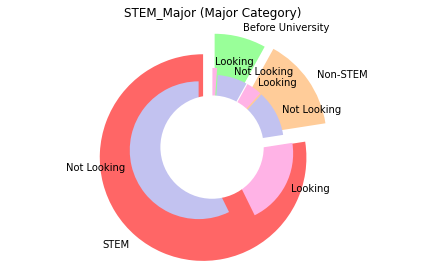

In [ ]:
# 시각화 (파이차트)
labels = ['STEM', 'Non-STEM', 'Before University']
sizes = [11872, 2220, 1234]
labels_gender = ['Not Looking', 'Looking','Not Looking', 'Looking', 'Not Looking', 'Looking']
sizes_gender = [8778,3094, 1659,561,1067, 167]
colors = ['#ff6666', '#ffcc99', '#99ff99']
colors_gender = ['#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6']
explode = (0.4, 0.4, 0.3) 
explode_gender = (0.4,0.4,0.1, 0.1,0.1, 0.3)
#Plot
plt.pie(sizes, 
        labels=labels, 
        colors=colors, 
        startangle=90,
        frame=True, 
        explode=explode,
        radius=3)

plt.pie(sizes_gender,
        labels = labels_gender, 
        colors=colors_gender,
        startangle=90, 
        explode=explode_gender,
        radius=2 )
#Draw circle
centre_circle = plt.Circle((0,0),1.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('STEM_Major (Major Category)')
plt.axis('equal')
plt.tight_layout()
plt.show()

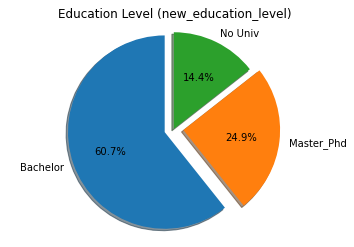

In [ ]:
labels = ['Bachelor', 'Master_Phd', 'No Univ']


sizes = [0.607073, 0.248793,0.144134]
explode = (0.1, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Education Level (new_education_level)')
plt.show()

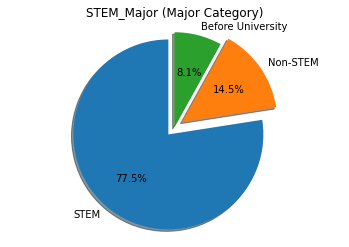

In [ ]:
labels = ['STEM', 'Non-STEM', 'Before University']


sizes = [0.774631, 0.144852, 0.080517]
explode = (0.1, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('STEM_Major (Major Category)')
plt.show()

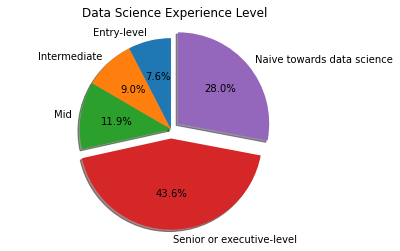

In [ ]:
labels = ['Entry-level', 'Intermediate', 'Mid', 'Senior or executive-level', 'Naive towards data science']


sizes = [0.075819, 0.090043, 0.118752, 0.435600, 0.279786]
explode = (0, 0, 0, 0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Data Science Experience Level')
plt.show()

In [ ]:
labels = ['Not Looking for Job Change', 'Looking for Job Change']
sizes = [0.75062, 0.24938]
explode = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Target')
plt.show()

# Code Summary - 이전 코드 요약

### 결측치

In [ ]:
def data_missing_value(df):

###########################################################
# -------------Experience Related Features--------------- #
###########################################################
  # 관련경험을 제외한 모든 experience related feature에 결측값이 있는 경우
  cond = ((df['last_new_job'].isnull()) &
        (df['company_size'].isnull()) & 
        (df['company_type'].isnull()) & 
        (df['experience'].isnull())
        )
  

  df.loc[cond, 'last_new_job'] = 'never'
  df.loc[cond, 'company_size'] = 'No current Job'
  df.loc[cond, 'company_type'] = 'No current Job'
  df.loc[cond, 'experience'] = 0

#### ---#### ---------------------------- 'experience' ---------------------------- ####
  experience_features = ['relevent_experience', 'experience','last_new_job', 'company_size', 'company_type']
# NaN in 'experience' having 'last_new_job' value
  exp_missing = ((df['experience'].isnull()) &
               ~(df['last_new_job'].isnull()) 
               )
## Replace them into the equal info of 'last_new_job'
  df.loc[exp_missing, 'experience'] = df.loc[exp_missing, 'last_new_job']

# -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - #
# Company informations exist without either 'experience' or 'last_new_job' info
  exp_missing2 = ((df['experience'].isnull()) &
               ~(df['company_size'].isnull() & df['company_type'].isnull()) 
               )
## Replace them into '<1' as the minimum
  df.loc[exp_missing2, 'experience'] = '<1'
  df.loc[exp_missing2, 'experience'] = '1'


# -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - #
# Replace them into...
  df['experience'] = df['experience'].str.replace('>20','20') # '>20' -> 20
  df['experience'] = df['experience'].str.replace('<1','0.5') # '<1' -> 0.5 
  df['experience'] = df['experience'].str.replace('>4','4.5') # '>4' -> 5 
  df['experience'] = df['experience'].str.replace('never','0') # 'never' -> 0 

# -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - #
# Other missing values of 'experience' = 0 & 'last_new_job' = 'never'
  exp_missing3 = (df['experience'].isnull())
  df.loc[exp_missing3,'experience'] = '0'

  exp_missing3 = (df['last_new_job'].isnull())
  df.loc[exp_missing3,'last_new_job'] = 'never'

# Convert it into integer
  df['experience'] = df['experience'].astype('float')


###################################################################################
#### ------------------- 'company_type' & 'company_size' ------------------- ####
# Randomized values based on prior distribution of individual company type or size to fill out missing values of each

# type list & size list
  company_type_list = df['company_type'].value_counts().index.tolist()
  company_size_list = df['company_size'].value_counts().index.tolist()

# -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - #
#### ---------------------------- 'company_size' ---------------------------- ####
### ------- Data wrangling with 'company_type' &'company_size' features ------ ###
  type_per_size = (df
  .groupby(['company_type','company_size'])
  .count()
  .reset_index()[['company_type','company_size','city']]
  .rename(columns = {'city': 'count'}))


# Creat Ratio of individual company_type with respect to comany_size
  for i in range(len(company_type_list)):
    cond = (type_per_size['company_type'] == company_type_list[i])
  # Total Counts 
    type_per_size.loc[cond,'sum'] = type_per_size[cond]['count'].sum()
  # Ratio
    type_per_size.loc[cond,'ratio'] = type_per_size[cond]['count']/type_per_size.loc[cond,'sum']


#### ------------------- company size 분포추출 및 결측치처리 ------------------- ####
  for i in range(len(company_type_list)):
  # 각 company_type별 company_size 분포도 추출하기 (list_ratio)
    cond_type_list_groupby = (type_per_size['company_type'] == company_type_list[i])
    size_list = type_per_size['company_size'][cond_type_list_groupby].values.tolist()
    list_ratio = type_per_size['ratio'][cond_type_list_groupby].values.tolist()

  # df 해당 company_type 추출
    cond_type_list_df = (df['company_type'] == company_type_list[i])
  # 해당 company_type의 company_size 결측치 뽑기
    cond_df_company_size_missing = ( (df['company_size'].isnull()) & (cond_type_list_df) )
  # 개별 type 또는 size의 분포도를 반영하여 random하게 뽑기
    np.random.seed(42)
    rand_company_size = pd.Series(np.random.choice(size_list,
                                                 p=list_ratio, 
                                                 size = cond_df_company_size_missing.sum())
                               )

  # Random하게 뽑은 형태로 결측치 처리 ('company_size')
    ind = df[cond_df_company_size_missing].index.to_list() # 해당 index 추출
    for index in range(cond_df_company_size_missing.sum()):
      df.loc[ind[index], 'company_size'] = rand_company_size[index]

# -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - #

#### ---------------------------- 'company_type' ---------------------------- ####
### ------- Data wrangling with 'company_type' &'company_size' features ------ ###
  size_per_type = (df
  .groupby(['company_size','company_type'])
  .count()
  .reset_index()[['company_size','company_type','city']]
  .rename(columns = {'city': 'count'}))

# Creat Ratio of individual company_type with respect to comany_size
  for i in range(len(company_size_list)):
    cond = (size_per_type['company_size'] == company_size_list[i])
  # Total Counts 
    size_per_type.loc[cond,'sum'] = size_per_type[cond]['count'].sum()
  # Ratio
    size_per_type.loc[cond,'ratio'] = size_per_type[cond]['count']/size_per_type.loc[cond,'sum']


#### ------------------- company_type 분포추출 및 결측치처리 ------------------- ####
  for i in range(len(company_size_list)):
  # 각 company_type별 company_size 분포도 추출하기 (list_ratio)
    cond_size_list_groupby = (size_per_type['company_size'] == company_size_list[i])
    type_list = size_per_type['company_type'][cond_size_list_groupby].values.tolist()
    list_ratio = size_per_type['ratio'][cond_size_list_groupby].values.tolist()

  # df의 해당 company_type 추출
    cond_size_list_df = (df['company_size'] == company_size_list[i])
  # 해당 company_type의 company_size 결측치 뽑기
    cond_df_company_type_missing = ( (df['company_type'].isnull()) & (cond_size_list_df) )
  # 개별 type 또는 size의 분포도를 반영하여 random하게 뽑기
    np.random.seed(42)
    rand_company_type = pd.Series(np.random.choice(type_list,
                                                 p=list_ratio, 
                                                 size = cond_df_company_type_missing.sum())
                                )
  
  # Random하게 뽑은 형태로 결측치 처리 ('company_type')
    ind = df[cond_df_company_type_missing].index.to_list() # 해당 index 추출
    for index in range(cond_df_company_type_missing.sum()):
      df.loc[ind[index], 'company_type'] = rand_company_type[index]

# -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - #

# ------------------------ Others without current job -----------------------------#
  df['company_size'].fillna('No current Job', inplace = True)
  df['company_type'].fillna('No current Job', inplace = True)


###########################################################
# -------------Education Related Features--------------- #
###########################################################

# 1. Degree가 있는데 No Major -> Other
  education_features = ['major_discipline', 'enrolled_university', 'education_level']
  university_degree = ['Graduate', 'Masters', 'Phd'] # University degree list
  df['major_discipline'] = df['major_discipline'].str.replace('No Major', 'Other')

# -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - #
# 2. University Degree에 속하지 않으면서 university course에 등록하지 않은 경우 (no_enrollment) ---> 'Before University'로 대체

# if education level is in university degree list without enrolled university courses
## Those who has "High School" education Level with any enrolled university courses 
## is a university student seeking an intership or a job
  cond = ( ~(df['education_level'].isin(university_degree)) & (df['enrolled_university'] == 'no_enrollment') ) 

# Education level upto High School or nothing with no_enrollment of university course
## Replace them into 'Before University'
  df['major_discipline'][cond] = 'Before University'


# -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - #
# 3. Phd이면서 university course가 결측치 ----> 'no_enrollment
## Reason: There would be no need to enroll any course after Phd
  cond = (df['education_level'] == 'Phd') & (df['enrolled_university'].isnull())
  df.loc[cond, 'enrolled_university'] = 'no_enrollment'



# -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - #
# 4. 셋 전부 결측치
## 4.1  관련 경험이 있는 경우
  cond = ((df['education_level'].isnull()) &
        (df['enrolled_university'].isnull()) &
        (df['major_discipline'].isnull()) &
        (df['relevent_experience'] == 'Has relevent experience')
        )

# 해당 결측치 대체
  df.loc[cond,'enrolled_university'] = 'no_enrollment'
  df.loc[cond,'education_level'] = 'Graduate'
  df.loc[cond,'major_discipline'] = 'STEM'

## 4.2 관련경험이 없는 경우
# Experience가 2년 이하
  cond = ((df['education_level'].isnull()) &
        (df['enrolled_university'].isnull()) &
        (df['major_discipline'].isnull()) &
        (df['relevent_experience'] == 'No relevent experience') &
        (df['experience'] <= 2)
        )

  df.loc[cond,'enrolled_university'] = 'Full time course'
  df.loc[cond,'education_level'] = 'High School'



# Experience가 2년 초과
  cond = ((df['education_level'].isnull()) &
        (df['enrolled_university'].isnull()) &
        (df['major_discipline'].isnull()) &
        (df['relevent_experience'] == 'No relevent experience') &
        (df['experience'] > 2)
        )

  df.loc[cond,'enrolled_university'] = 'no_enrollment'
  df.loc[cond,'education_level'] = 'High School'
  df.loc[cond,'major_discipline'] = 'Before University'

# 4.3 나머지 education_level 결측치 처리
# 관련 경험이 있는 경우
  cond = ((df['education_level'].isnull()) & 
        (df['enrolled_university'] != 'no_enrollment') &
        (df['relevent_experience'] == 'Has relevent experience')
        )

  df.loc[cond,'education_level'] = 'High School'
  df.loc[cond,'major_discipline'] = 'STEM'


# 4.4 관련경험이 없는 경우: Randomized Value for Major
  cond = ((df['education_level'].isnull()) & 
        (df['enrolled_university'] != 'no_enrollment') &
        (df['relevent_experience'] != 'Has relevent experience')
        )

## Education level은 High School로 대체
  df.loc[cond,'education_level'] = 'High School'

## Major: Randomized Value
### Data Wrangline
  data_wrangling = (df
    .groupby(['major_discipline'])
    .count()
    .reset_index()[['major_discipline','city']]
    .rename(columns = {'city': 'count'}))
### Choose onlt university degree except both 'STEM' and 'Before University'
  Not_STEM = ['Arts', 'Business Degree', 'Humanities', 'Other']
  cond = data_wrangling['major_discipline'].isin(Not_STEM)
  data_wrangling_filtered = data_wrangling[cond]

### Ratio
  data_wrangling_filtered['ratio'] = data_wrangling_filtered['count']/data_wrangling_filtered['count'].sum()

  Not_STEM_list = data_wrangling_filtered['major_discipline'].values.tolist()

#### ------------------- 분포추출 및 결측치처리 ------------------- ####
  for i in range(len(Not_STEM_list)):
  # 개별 type 또는 size의 분포도를 반영하여 random하게 뽑기
    cond_df_missing = ((df['education_level'].isnull()) & 
                     (df['enrolled_university'] != 'no_enrollment') &
                     (df['relevent_experience'] != 'Has relevent experience')
                     )

    np.random.seed(42)
    rand_major_type = pd.Series(np.random.choice(Not_STEM_list,
                                                 p=data_wrangling_filtered['ratio'], 
                                                 size = cond_df_missing.sum())
                                )
  
  # Random하게 뽑은 형태로 결측치 처리 (main)
    ind = df[cond_df_missing].index.to_list() # 해당 index 추출
    for index in range(cond_df_missing.sum()):
      df.loc[ind[index], 'major_discipline'] = rand_major_type[index]


# -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - #
# eudcation level 나머지
  cond = df['education_level'].isnull()
  df.loc[cond, 'education_level'] = 'High School'


# enrolled_university 결측치 처리
# Graduate
## experience <= 1
  cond = ((df['enrolled_university'].isnull()) & 
        (df['education_level'] == 'Graduate') & 
        (df['experience'] <= 1)
        )
  df.loc[cond,'enrolled_university'] = 'Full time course'
## experience > 1
  cond = ((df['enrolled_university'].isnull()) & 
        (df['education_level'] == 'Graduate') & 
        (df['experience'] > 1)
        )
  df.loc[cond,'enrolled_university'] = 'no_enrollment'


# -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - #
# Masters
## experience <= 2
  cond = ((df['enrolled_university'].isnull()) & 
        (df['education_level'] == 'Masters') & 
        (df['experience'] <= 2)
        )
  df.loc[cond,'enrolled_university'] = 'Full time course'
## experience > 2
  cond = ((df['enrolled_university'].isnull()) & 
        (df['education_level'] == 'Masters') & 
        (df['experience'] > 2)
        )
  df.loc[cond,'enrolled_university'] = 'no_enrollment'


# -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - #
# High School
## experience <= 2
  cond = ((df['enrolled_university'].isnull()) & 
        (df['education_level'] == 'High School') & 
        (df['experience'] <= 2)
        )
  df.loc[cond,'enrolled_university'] = 'Full time course'
## experience > 2
  cond = ((df['enrolled_university'].isnull()) & 
        (df['education_level'] == 'High School') & 
        (df['experience'] > 2)
        )
  df.loc[cond,'enrolled_university'] = 'no_enrollment'


# -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - #
# Primary School

  cond = ((df['enrolled_university'].isnull()) & 
        (df['education_level'] == 'Primary School')
        )
  df.loc[cond,'enrolled_university'] = 'no_enrollment'


# -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - #
# major_discipline
# 대학수업 수강 안하고 최종학력이 university degree가 아닌 경우
  cond = ((df['major_discipline'].isnull()) & 
        (df['enrolled_university'] == 'no_enrollment') & 
        ~(df['education_level'].isin(university_degree))
        )
  df.loc[cond, 'major_discipline'] = 'Before University'


# -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - #
## 관련경험이 있는 경우
  cond = ((df['major_discipline'].isnull()) & 
        (df['relevent_experience'] == 'Has relevent experience')
        )
  df.loc[cond, 'major_discipline'] = 'STEM'


# -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - #
## 관련경험이 없는 경우: Randomized Value

## Data Wrangline
  data_wrangling = (df
    .groupby(['major_discipline'])
    .count()
    .reset_index()[['major_discipline','city']]
    .rename(columns = {'city': 'count'}))
## Choose onlt university degree except both 'STEM' and 'Before University'
  Not_STEM = ['Arts', 'Business Degree', 'Humanities', 'Other']
  cond = data_wrangling['major_discipline'].isin(Not_STEM)
  data_wrangling_filtered = data_wrangling[cond]

## Ratio
  data_wrangling_filtered['ratio'] = data_wrangling_filtered['count']/data_wrangling_filtered['count'].sum()

  Not_STEM_list = data_wrangling_filtered['major_discipline'].values.tolist()

#### ------------------- 분포추출 및 결측치처리 ------------------- ####
  for i in range(len(Not_STEM_list)):
  # 개별 type 또는 size의 분포도를 반영하여 random하게 뽑기
    cond_df_missing = ((df['major_discipline'].isnull()) &  
                     (df['relevent_experience'] != 'Has relevent experience')
                     )
    np.random.seed(42)
    rand_major_type = pd.Series(np.random.choice(Not_STEM_list,
                                                 p=data_wrangling_filtered['ratio'], 
                                                 size = cond_df_missing.sum())
                                )
  
  # Random하게 뽑은 형태로 결측치 처리 (main)
    ind = df[cond_df_missing].index.to_list() # 해당 index 추출
    for index in range(cond_df_missing.sum()):
      df.loc[ind[index], 'major_discipline'] = rand_major_type[index]



# -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - #
# Gender
## Data Wrangline
  data_wrangling_gender = (df
    .groupby(['major_discipline', 'gender'])
    .count()
    .reset_index()[['major_discipline', 'gender', 'city']]
    .rename(columns = {'city': 'count'}))

  major_list = df['major_discipline'].values.tolist()

# Creat Ratio of individual gender type with respect to Major
  for i in range(len(major_list)):
    cond = (data_wrangling_gender['major_discipline'] == major_list[i])
  # Total Counts 
    data_wrangling_gender.loc[cond,'sum'] = data_wrangling_gender[cond]['count'].sum()
  # Ratio
    data_wrangling_gender.loc[cond,'ratio'] = data_wrangling_gender[cond]['count']/data_wrangling_gender.loc[cond,'sum']


  for i in range(len(major_list)):
  # 각 Major의 gender type 분포도 추출하기 (list_ratio)
    cond_groupby = (data_wrangling_gender['major_discipline'] == major_list[i])
    gender_list = data_wrangling_gender['gender'][cond_groupby].values.tolist()
    list_ratio = data_wrangling_gender['ratio'][cond_groupby].values.tolist()

  # 해당 major의 따른 Gender 결측치 추출
    cond_major_df = (df['major_discipline'] == major_list[i])
    cond_missing_df = ( (df['gender'].isnull()) & (cond_major_df) )
  # 개별 type 또는 size의 분포도를 반영하여 random하게 뽑기
    np.random.seed(42)
    rand_gender = pd.Series(np.random.choice(gender_list,
                                           p=list_ratio, 
                                           size = cond_missing_df.sum())
                         )

  # Random하게 뽑은 형태로 결측치 처리 ('company_size')
    ind = df[cond_missing_df].index.to_list() # 해당 index 추출
    for index in range(cond_missing_df.sum()):
      df.loc[ind[index], 'gender'] = rand_gender[index]
  return df

In [ ]:
data_missing_value(test)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9.0,<10,Pvt Ltd,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5.0,1000-4999,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,Before University,0.5,<10,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11.0,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,20.0,10000+,Pvt Ltd,>4,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,1289,city_103,0.920,Male,No relevent experience,no_enrollment,Graduate,Humanities,16.0,1000-4999,Public Sector,4,15
2125,195,city_136,0.897,Male,Has relevent experience,no_enrollment,Masters,STEM,18.0,No current Job,No current Job,2,30
2126,31762,city_100,0.887,Male,No relevent experience,no_enrollment,Primary School,Before University,3.0,10000+,Pvt Ltd,never,18
2127,7873,city_102,0.804,Male,Has relevent experience,Full time course,High School,STEM,7.0,100-500,Public Sector,1,84


### 데이터가공

In [ ]:
def feature_engineering(df):

###########################################################
# -------------Delete unnecessary Features--------------- #
###########################################################

  del_features = ['enrollee_id', 'city']
  df.drop(del_features, axis = 1, inplace = True)

###########################################################
# ------------Data Science Experience Level-------------- #
###########################################################

# Experience_level
  def ds_experience_level(x):
    if x <= 3:
      level = 'Entry'
    elif x <= 5:
      level = 'Intermediate'
    elif x <= 8:
      level = 'Mid'
    else:
      level = 'Senior'
    return level

# If a candidate has a relevent experience, accept it as data science job experience
  cond_relevent = (df['relevent_experience'] == 'Has relevent experience')

  df.loc[cond_relevent, 'ds_experience_level'] = df.loc[cond_relevent, 'experience'].apply(lambda x: ds_experience_level(x))

# otherwise, 'Naive towards data science'
  df.loc[~cond_relevent, 'ds_experience_level'] = 'Naive towards data science'

  df['ds_experience_level'].value_counts(normalize = True)

###########################################################
# ----------------Experience of Turnover----------------- #
###########################################################
  cond = (df['last_new_job'].isin(['never'])) & (df['company_size'] != 'No current Job')

  df['experience_of_turnover'] = 1
  df.loc[cond, 'experience_of_turnover'] = 0
  df['experience_of_turnover'].value_counts(normalize = True)

###########################################################
# -----------------------STEM_Major---------------------- #
###########################################################

# STEM Majors
  df['STEM_Major'] = 'STEM'

# Non-STEM Majors
  Non_STEM_list = ['Humanities', 'Other', 'Business Degree', 'Arts']
  cond_non_stem = df['major_discipline'].isin(Non_STEM_list)
  df.loc[cond_non_stem, 'STEM_Major'] = 'Non-STEM'

# No University Degree
  cond_before_univ = (df['major_discipline'] == 'Before University')
  df.loc[cond_before_univ, 'STEM_Major'] = 'Before University'

# Delete 'major_discipline' 
  df.drop('major_discipline', axis = 1, inplace = True)

###########################################################
# -----------------company_size_category----------------- #
###########################################################

# size list
  small_list = ['<10', '10/49', '50-99']
  medium_list = ['100-500', '500-999']
  large_list = ['1000-4999', '5000-9999','10000+']

# Conditional Statement by size-categories
  cond_small = df['company_size'].isin(small_list)
  cond_medium = df['company_size'].isin(medium_list)
  cond_large = df['company_size'].isin(large_list)
  cond_no_job = df['company_size'] == 'No current Job'
# Create a 'company_size_category' feature
  df.loc[cond_small, 'company_size_category'] = 'Small'
  df.loc[cond_medium, 'company_size_category'] = 'Medium'
  df.loc[cond_large, 'company_size_category'] = 'Large'
  df.loc[cond_no_job, 'company_size_category'] = 'No current Job'

# Delete Company Size
  df.drop('company_size', axis = 1, inplace = True)
  df['company_size_category'].value_counts(normalize = True)


###########################################################
# -------------------New_company_type-------------------- #
###########################################################


# Combined type list
  startup_list = ['Funded Startup', 'Early Stage Startup']
  NGO_Other_list = ['NGO', 'Other']

# Conditional Statement 
  cond_start = df['company_type'].isin(startup_list)
  cond_ngo = df['company_type'].isin(NGO_Other_list)
  cond_pvt = df['company_type'] == 'Pvt Ltd'
  cond_public = df['company_type'] == 'Public Sector'
  cond_no_job = df['company_type'] == 'No current Job'


# Create a 'New_company_type' feature
  df.loc[cond_start, 'New_company_type'] = 'Startup'
  df.loc[cond_ngo, 'New_company_type'] = 'NGO_Other'
  df.loc[cond_pvt, 'New_company_type'] = 'Pvt Ltd'
  df.loc[cond_public, 'New_company_type'] = 'Public Sector'
  df.loc[cond_no_job, 'New_company_type'] = 'No current Job'

# Delete Company Size
  df.drop('company_type', axis = 1, inplace = True)
  df['New_company_type'].value_counts(normalize = True)

###########################################################
# ------------------New_education_level------------------ #
###########################################################

  # size list
  bachelor_list = ['Graduate']
  master_phd_list = ['Masters', 'Phd']
  no_degree_list = ['High School', 'Primary School']

  # Conditional Statement by size-categories
  cond_bachelor = df['education_level'].isin(bachelor_list)
  cond_master_phd = df['education_level'].isin(master_phd_list)
  cond_no_degree = df['education_level'].isin(no_degree_list)

  # Create a 'new_education_level' feature
  df.loc[cond_bachelor, 'new_education_level'] = 'Bachelor'
  df.loc[cond_master_phd, 'new_education_level'] = 'Master_Phd'
  df.loc[cond_no_degree, 'new_education_level'] = 'No Univ'

  # Delete Company Size
  df.drop('education_level', axis = 1, inplace = True)
  df['new_education_level'].value_counts(normalize = True)

  return df

In [ ]:
feature_engineering(test)

,city_development_index,gender,relevent_experience,enrolled_university,experience,last_new_job,training_hours,ds_experience_level,experience_of_turnover,STEM_Major,company_size_category,New_company_type,new_education_level
0,0.827,Male,Has relevent experience,Full time course,9.0,1,21,Senior,1,STEM,Small,Pvt Ltd,Bachelor
1,0.920,Female,Has relevent experience,no_enrollment,5.0,1,98,Intermediate,1,STEM,Large,Pvt Ltd,Bachelor
2,0.624,Male,No relevent experience,no_enrollment,0.5,never,15,Naive towards data science,0,Before University,Small,Pvt Ltd,No Univ
3,0.827,Male,Has relevent experience,no_enrollment,11.0,1,39,Senior,1,STEM,Small,Pvt Ltd,Master_Phd
4,0.920,Male,Has relevent experience,no_enrollment,20.0,>4,72,Senior,1,STEM,Large,Pvt Ltd,Bachelor
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,0.920,Male,No relevent experience,no_enrollment,16.0,4,15,Naive towards data science,1,Non-STEM,Large,Public Sector,Bachelor
2125,0.897,Male,Has relevent experience,no_enrollment,18.0,2,30,Senior,1,STEM,No current Job,No current Job,Master_Phd
2126,0.887,Male,No relevent experience,no_enrollment,3.0,never,18,Naive towards data science,0,Before University,Large,Pvt Ltd,No Univ
2127,0.804,Male,Has relevent experience,Full time course,7.0,1,84,Mid,1,STEM,Medium,Public Sector,No Univ


In [ ]:
y_train.value_counts(normalize = True)

target
0.0       0.750652
1.0       0.249348
dtype: float64

### 데이터 나누기 (학습용, 테스트용, 검증용)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train)

In [ ]:
y_train.value_counts(normalize = True)

target
0.0       0.75062
1.0       0.24938
dtype: float64

In [ ]:
y_val.value_counts(normalize = True)

target
0.0       0.750783
1.0       0.249217
dtype: float64

# 모델링

1. Logistic Regression
2. Random Forest
3. XGBoost
4. LightGBM

**성능지표:** ROC-AUC Curve 

**이유:** 정확도 뿐만 아니라 정밀도(Precision)과 재현율(Recall)을 통해 분류하여 정확도(Accuracy)에만 치우치지 않는 분류모델을 만들기 위해서

## Logistic Regression

In [ ]:
pipe_logistic = make_pipeline(TargetEncoder(smoothing = 1),
                              LogisticRegressionCV(random_state = 42, cv = 5)
                              )


pipe_logistic.fit(X_train, y_train)

# ROC-AUC Curve / ROC Curve
y_pred_val = pipe_logistic.predict(X_val)
y_pred_train = pipe_logistic.predict(X_train)

logistic_score_train = roc_auc_score(y_pred_train, y_train)
logistic_score_val = roc_auc_score(y_pred_val, y_val)

print("------------------------------------------------")
print("------Roc-Auc Curve-----")
print("Train:", logistic_score_train)
print("Validation:", logistic_score_val)

------------------------------------------------
------Roc-Auc Curve-----
Train: 0.6873233216187296
Validation: 0.6816111408488577


## Random Forest

In [ ]:
pipe_rf = make_pipeline(TargetEncoder(smoothing = 1),
                        RandomForestClassifier(n_estimators = 500)
                        )

param_dict = {
    "randomforestclassifier__max_depth": randint(1, 50),
    'randomforestclassifier__max_features': uniform(0,1),
    'randomforestclassifier__min_samples_split': randint(1, 50),
    'randomforestclassifier__min_samples_leaf': randint(1, 50),
}
            
random_grid_rf = RandomizedSearchCV(pipe_rf,
                                 param_distributions = param_dict,
                                 n_iter = 200,
                                 scoring = 'roc_auc',
                                 random_state = 42,
                                 cv = 3,
                                 verbose = 1,
                                 n_jobs = -1
                                 )
random_grid_rf.fit(X_train, y_train)
print("Best parameter:",random_grid_rf.best_params_)
print('Roc-Auc Curve: ', random_grid_rf.best_score_)

# ---------------------------scoring -------------------------#

# The best Random Forest Model
best_rf = random_grid_rf.best_estimator_

# ROC-AUC Curve / ROC Curve
y_pred_val = best_rf.predict(X_val)
y_pred_train = best_rf.predict(X_train)

rf_score_train = roc_auc_score(y_pred_train, y_train)
rf_score_val = roc_auc_score(y_pred_val, y_val)

print("------------------------------------------------")
print("------Roc-Auc Curve-----")
print("Train:", rf_score_train)
print("Validation:", rf_score_val)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Best parameter: {'randomforestclassifier__max_depth': 8, 'randomforestclassifier__max_features': 0.7290071680409873, 'randomforestclassifier__min_samples_leaf': 33, 'randomforestclassifier__min_samples_split': 5}
Roc-Auc Curve:  0.8012290699469399
------------------------------------------------
------Roc-Auc Curve-----
Train: 0.7437485408680096
Validation: 0.7369947547891978


## XGBoost

In [ ]:
from xgboost import XGBClassifier
pipe_xgb = make_pipeline(TargetEncoder(smoothing = 1),
                        XGBClassifier(objective = 'binary:logistic', 
                                      n_estimators = 500,
                                      seed = 42,
                                      eval_metric = 'auc')
                        )

param_dict = {
    "xgbclassifier__max_depth": randint(1,10),
    'xgbclassifier__min_child_weight': randint(10, 20),
    'xgbclassifier__gamma': uniform(0,1),
    'xgbclassifier__subsample': [0.5,0.6,0.7,0.8,0.9],
    'xgbclassifier__colsample_bytree': [0.5,0.6,0.7,0.8,0.9],
    'xgbclassifier__learning_rate': [0.05,0.06,0.07,0.08,0.09,0.1]
}
            
random_grid_xgb = RandomizedSearchCV(pipe_xgb,
                                 param_distributions = param_dict,
                                 n_iter = 200,
                                 scoring = 'roc_auc',
                                 random_state = 42,
                                 cv = 3,
                                 verbose = 1,
                                 n_jobs = -1
                                 )
random_grid_xgb.fit(X_train, y_train)
print("Best parameter:",random_grid_xgb.best_params_)
print('Roc-Auc Curve: ', random_grid_xgb.best_score_)

# ---------------------------scoring -------------------------#

# The best Random Forest Model
best_xgb = random_grid_xgb.best_estimator_

# ROC-AUC Curve / ROC Curve
y_pred_val = best_xgb.predict(X_val)
y_pred_train = best_xgb.predict(X_train)

xgb_score_train = roc_auc_score(y_pred_train, y_train)
xgb_score_val = roc_auc_score(y_pred_val, y_val)

print("------------------------------------------------")
print("------Roc-Auc Curve-----")
print("Train:", xgb_score_train)
print("Validation:", xgb_score_val)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Best parameter: {'xgbclassifier__colsample_bytree': 0.7, 'xgbclassifier__gamma': 0.5227328293819941, 'xgbclassifier__learning_rate': 0.06, 'xgbclassifier__max_depth': 3, 'xgbclassifier__min_child_weight': 16, 'xgbclassifier__subsample': 0.5}
Roc-Auc Curve:  0.8009006222392362
------------------------------------------------
------Roc-Auc Curve-----
Train: 0.7429933495315292
Validation: 0.7289891154502993


## LightGBM

In [ ]:
from lightgbm import LGBMClassifier
pipe_lgbm = make_pipeline(TargetEncoder(smoothing = 1),
                        LGBMClassifier(random_state=42, 
                                       silent=True, 
                                       metric='auc', 
                                       n_jobs=-1, 
                                       n_estimators=500)
                        )





parameters ={'lgbmclassifier__num_leaves': randint(6, 50), 
             'lgbmclassifier__min_child_samples': randint(100, 500), 
             'lgbmclassifier__min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'lgbmclassifier__subsample': uniform(loc=0.2, scale=0.8), 
             'lgbmclassifier__colsample_bytree': uniform(loc=0.4, scale=0.6),
             'lgbmclassifier__reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'lgbmclassifier__reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'lgbmclassifier__learning_rate': [0.05,0.06,0.07,0.08,0.09,0.1]
            }



random_grid_lgbm = RandomizedSearchCV(pipe_lgbm,
                                 param_distributions = parameters,
                                 n_iter = 200,
                                 scoring = 'roc_auc',
                                 random_state = 42,
                                 cv = 3,
                                 verbose = 1,
                                 n_jobs = -1,  
                                 )


random_grid_lgbm.fit(X_train, y_train)
print("Best parameter:",random_grid_lgbm.best_params_)
print('Roc-Auc Curve: ', random_grid_lgbm.best_score_)
# The best Random Forest Model
best_lgbm = random_grid_lgbm.best_estimator_

# ROC-AUC Curve / ROC Curve
y_pred_val = best_lgbm.predict(X_val)
y_pred_train = best_lgbm.predict(X_train)

lgbm_score_train = roc_auc_score(y_pred_train, y_train)
lgbm_score_val = roc_auc_score(y_pred_val, y_val)

print("------------------------------------------------")
print("------Roc-Auc Curve-----")
print("Train:", lgbm_score_train)
print("Validation:", lgbm_score_val)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Best parameter: {'lgbmclassifier__colsample_bytree': 0.672724638860664, 'lgbmclassifier__learning_rate': 0.09, 'lgbmclassifier__min_child_samples': 153, 'lgbmclassifier__min_child_weight': 10.0, 'lgbmclassifier__num_leaves': 8, 'lgbmclassifier__reg_alpha': 10, 'lgbmclassifier__reg_lambda': 0, 'lgbmclassifier__subsample': 0.9322034733352851}
Roc-Auc Curve:  0.8018736976453288
------------------------------------------------
------Roc-Auc Curve-----
Train: 0.7352685860779589
Validation: 0.7319736333017747


## 성능비교

In [ ]:
score_df = pd.DataFrame([
    [0, logistic_score_train, logistic_score_val],
    [random_grid_rf.best_score_, rf_score_train, logistic_score_val],
    [random_grid_xgb.best_score_, xgb_score_train, xgb_score_val],
    [random_grid_lgbm.best_score_, lgbm_score_train, lgbm_score_val]],
    columns = ['Best Score', 'Train', 'Validation'],
    index = ['Logistic Regression', 'Random Forest', 'XGBoost','LightGBM']
)


(score_df.style.format("{:.4f}")
.highlight_max(['Best Score', 'Train', 'Validation'], color='orange')
)

,Best Score,Train,Validation
Logistic Regression,0.0000,0.6873,0.6816
Random Forest,0.8012,0.7437,0.6816
XGBoost,0.8009,0.7430,0.7290
LightGBM,0.8019,0.7353,0.7320


# 최종모델

* **The Best model is LightGBM!**

In [ ]:
# Preprocessing test dataset
data_missing_value(test)
feature_engineering(test)

# Set the Final Model and conduct a prediction
final_model = best_lgbm
y_pred = final_model.predict(test)



# 모델 결과 시각화

## PDP

In [ ]:
X_train.columns[0]

'city_development_index'

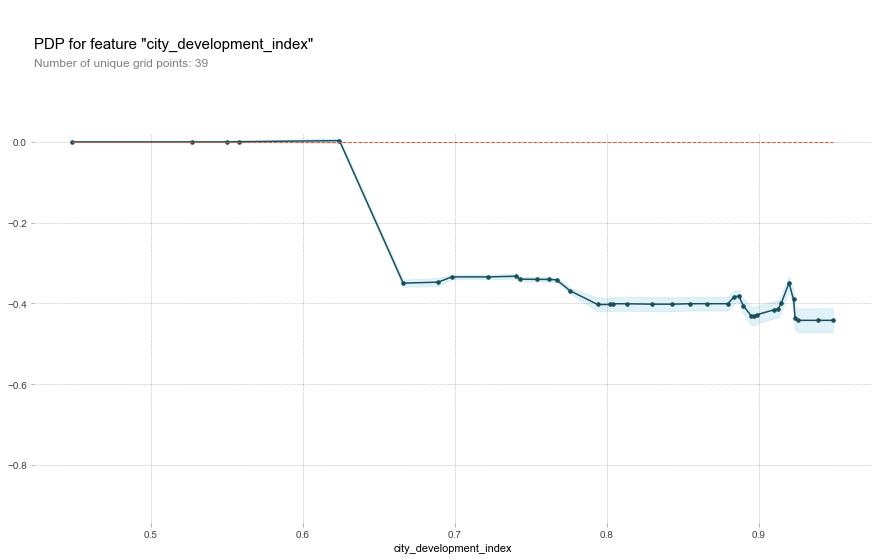

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
features = X_train.columns

feature = features[0]
isolated = pdp_isolate(
    model=final_model, 
    dataset=test_encoded, 
    model_features=test_encoded.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=100 # default=10
)
pdp_plot(isolated, feature_name=feature);

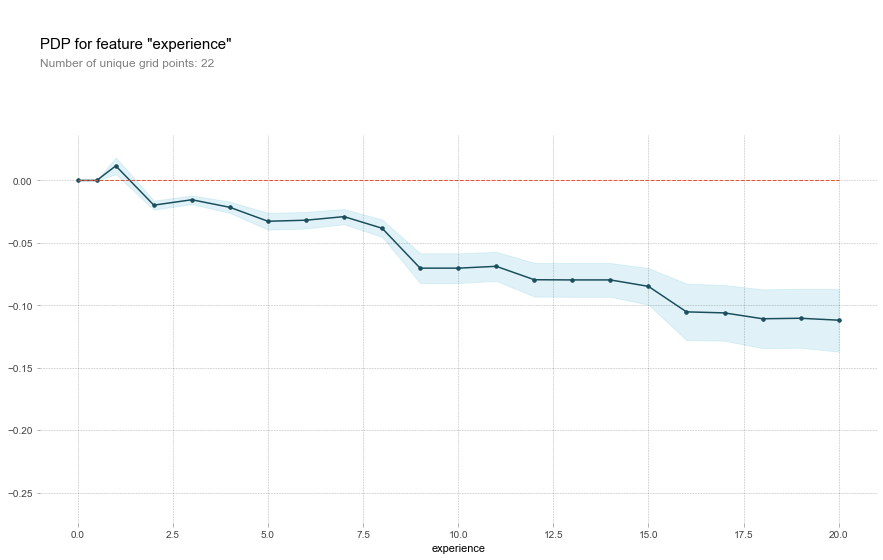

In [ ]:
feature = features[4]
isolated = pdp_isolate(
    model=final_model, 
    dataset=test_encoded, 
    model_features=test_encoded.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=100 # default=10
)
pdp_plot(isolated, feature_name=feature);

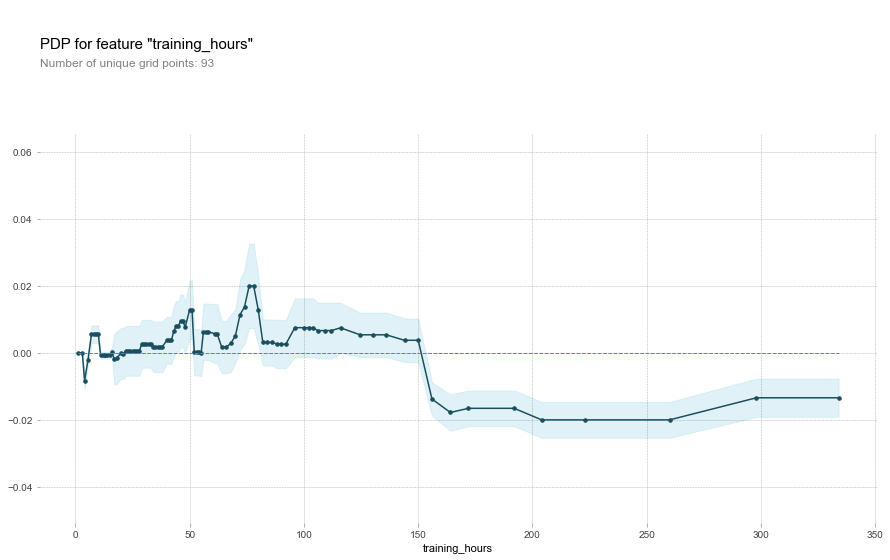

In [ ]:
feature = features[6]
isolated = pdp_isolate(
    model=final_model, 
    dataset=test_encoded, 
    model_features=test_encoded.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=100 # default=10
)
pdp_plot(isolated, feature_name=feature);

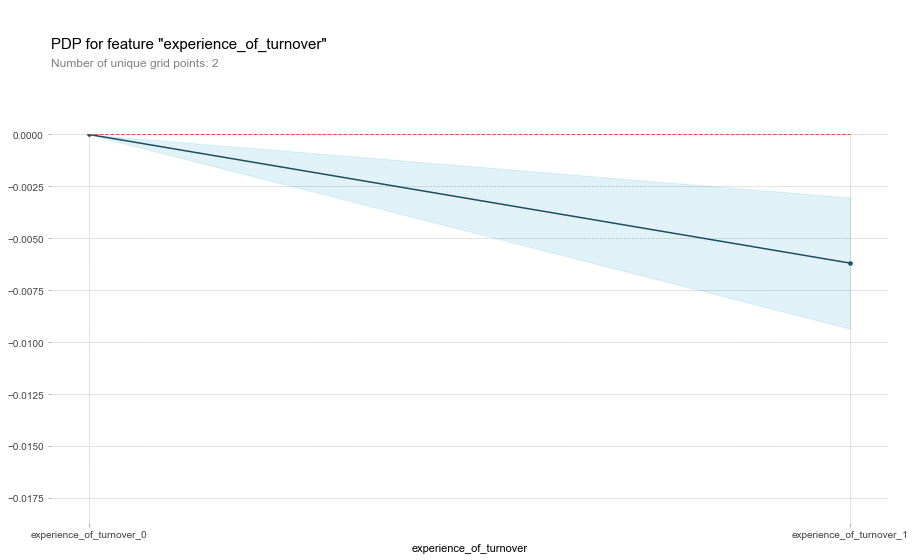

In [ ]:
feature = features[8]
isolated = pdp_isolate(
    model=final_model, 
    dataset=test_encoded, 
    model_features=test_encoded.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=100 # default=10
)
pdp_plot(isolated, feature_name=feature);

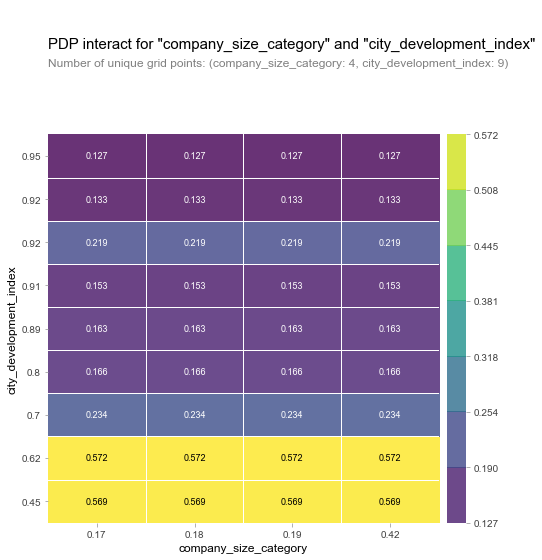

In [ ]:
# 2D PDP
feature_list= ['company_size_category', 'city_development_index']

interaction = pdp_interact(
    model=final_model, 
    dataset=test_encoded, 
    model_features=test_encoded.columns, 
    features=feature_list
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=feature_list);

## 트리모형 시각화

<AxesSubplot:>

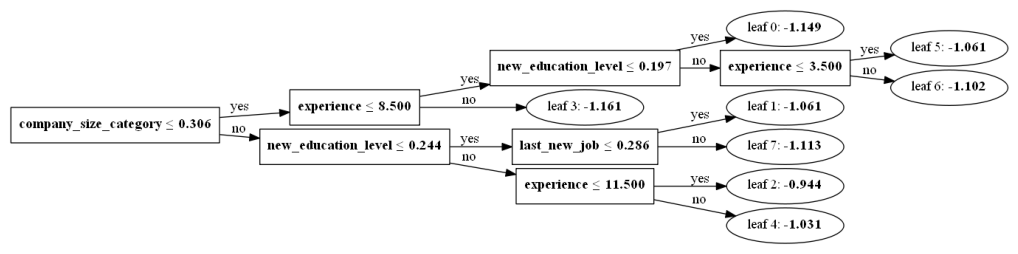

In [ ]:
import lightgbm as lgb
# 하이퍼파라미터 최적값을 통해 손으로 직접 Converting하기
# Encoder
encoder = TargetEncoder( cols=['gender', 'relevent_experience',
                                     'enrolled_university', 'last_new_job',
                                     'ds_experience_level', 'STEM_Major',
                                     'company_size_category',
                                     'New_company_type',
                                     'new_education_level'], smoothing=1.0)

X_train_encoded = encoder.fit_transform(X_train, y_train)
test_encoded = encoder.transform(test)

# LightGBM Model fit
model = LGBMClassifier(colsample_bytree=0.672724638860664,
                                learning_rate=0.09, metric='auc',
                                min_child_samples=153, min_child_weight=10.0,
                                n_estimators=500, num_leaves=8, random_state=42,
                                reg_alpha=10, reg_lambda=0,
                                subsample=0.9322034733352851)

model.fit(X_train_encoded, y_train)



lgb.plot_tree(model, figsize = (18,18))

## SHAP

In [ ]:
pipe_lgbm.named_steps['lgbmclassifier']

LGBMClassifier(metric='auc', n_estimators=500, random_state=42)

In [ ]:
import shap

# SHAP
explainer = shap.TreeExplainer(model)
row = test_encoded.iloc[[0]]
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(base_value = explainer.expected_value[0], 
                shap_values = shap_values[0], 
                features = row)



In [ ]:
test.iloc[[0]]

,city_development_index,gender,relevent_experience,enrolled_university,experience,last_new_job,training_hours,ds_experience_level,experience_of_turnover,STEM_Major,company_size_category,New_company_type,new_education_level
0,0.827,Male,Has relevent experience,Full time course,9.0,1,21,Senior,1,STEM,Small,Pvt Ltd,Bachelor


In [ ]:
row = test_encoded.iloc[[100]]
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(base_value = explainer.expected_value[0], 
                shap_values = shap_values[0], 
                features = row)



In [ ]:
test.iloc[[100]]

,city_development_index,gender,relevent_experience,enrolled_university,experience,last_new_job,training_hours,ds_experience_level,experience_of_turnover,STEM_Major,company_size_category,New_company_type,new_education_level
100,0.92,Male,No relevent experience,no_enrollment,3.0,>4,41,Naive towards data science,1,Before University,No current Job,No current Job,No Univ


* **전직 생각이 없는 사람들 (Target = 0)**

In [ ]:
shap.initjs()
shap_values = explainer.shap_values(test_encoded.loc[:300])
shap.force_plot(explainer.expected_value[0], shap_values[0], test_encoded.loc[:300])

* **전직 생각이 있는 사람들 (Target = 1)**

In [ ]:
shap.initjs()
shap_values = explainer.shap_values(test_encoded.loc[:300])
shap.force_plot(explainer.expected_value[1], shap_values[1], test_encoded.loc[:300])

### Feature Importance

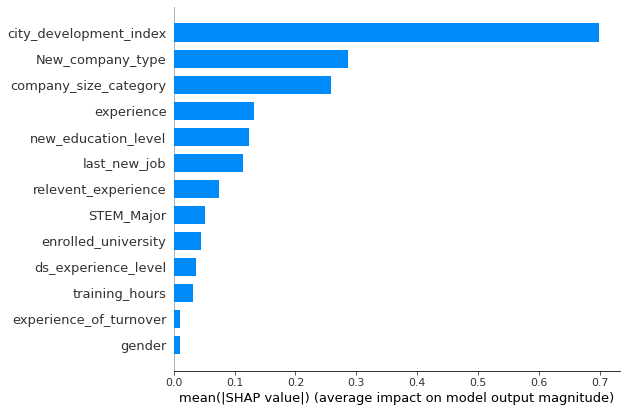

In [ ]:
# Target = 0
shap.initjs()
shap.summary_plot(shap_values[0], test_encoded.iloc[:300], plot_type="bar")

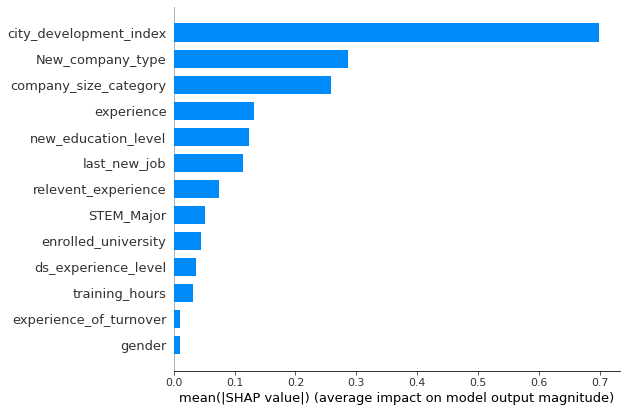

In [ ]:
# Target = 1
shap.initjs()
shap.summary_plot(shap_values[1], test_encoded.iloc[:300], plot_type="bar")

## 해석

* 속한 도시(City)의 발전도가 전직을 고려하게 많드는 주요한 요인이다.
* 현재 직장의 형태(Company_type)과 크기(Company Size) 또한 중요하다.
* 관련경험(Relevent_experience) 보다는 전체 커리어 경험(experience)이 더 영향을 준다
* **Data Science는 전공과는 무관하다. 즉, 비전공자도 할 수 있다.**
* 트레이닝 시간은 상대적으로 영향도가 낮다.
* 이직경험과 성별은 거의 영향이 없다.

In [ ]:
# Submission
submission = pd.DataFrame([pd.Series(test_id), pd.Series(y_pred)],
                         columns = ['enrollee_id', 'target'])

submission.to_csv('submission.csv', index = False)

# Apendix